El presente documento es un tutorial para calcular el indicador de riesgo de mercado conocido como Value at Risk (desde ahora en adelante VaR), utilizando los métodos: histórico, paramétrico y por simulación de montecarlo.

Para el cálculo y maniupalación de datos se utilizan las librerías:
- Pandas
- Numpy
- Yfinance
- Datetime
- Matplotlib
- Dateutil
- Scipy

La formade importarlas se muestra a continuación.

In [14]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, kurtosis, skew, chi2
from numpy.linalg import cholesky

# Obtener datos de mercado

Para el ejercio se utilizará un portafolio constituido por las acciones de Tesla, Apple, Facebook, Nvidia, Microsoft y Amazon, donde los tickers son respectivamente TSLA, AAPL, FB, NVDA, MSFT y AMZN. 

Para descargar los datos de mercado desde internet se utuliza la función *download()* de la librería *Yfinance*, importada como *yf*, la cual nos permite extraer datos desde **Yahoo Finance**. Para esto necesitamos los tickers de las acciones, una fecha de inicio y una de termino, estos datos deben ser datos de tipo *string*.

La descarga de datos se muestra a continuación.

In [15]:
# Get market data
tickers = ['TSLA', 'AAPL', 'FB', 'NVDA', 'MSFT', 'AMZN']
start = (dt.datetime.now() - relativedelta(years=5)).strftime('%Y-%m-%d')
df = yf.download(tickers,start)['Adj Close']

[*********************100%***********************]  6 of 6 completed


En la desacarga de datos se extraen 5 años exactos desde hoy, para estimar la fecha de 5 años atrás (inicio) se utilizan las funciones *datetime.now()* y *relativedelta* de las librerías *Datetime* y *Dateutil*. Un detalle a destacar es que si no se define una fecha de termino, está será por defecto la fecha de hoy, es por esto que no definimos fecha de termino en la función. Por último, para este ejercicio vamos a trabajar con los precios de cierre ajustados por dividendo, por lo que lo para forzar que solo nos entregue esa información agregamos "['Adj Close']".

# Métricas previas

Antes de calcular el VaR, debemos estimar algunas métricas de nustro portafolio como:

- retornos diariros
- promedio de retornos
- desviación estandar de los retornos
- precio actual del portafolio

A continuación se muestra el cálculo de estas métricas

In [16]:
# Define weights & estimate returns
weights = np.random.rand(len(tickers)) # random weights
weights /= np.sum(weights) # force total portfolio equal to one
port_ret = np.log(df/df.shift(1)).dropna() # logarithmic returns

#Get financials
ret = port_ret.mean().values
mean = np.dot(weights.T,ret)
cov = port_ret.cov()
std = np.sqrt(
        np.dot(weights.T,np.dot(cov,weights))
)
last_price = np.dot(df.iloc[-1].values,weights.T)

# Value at Risk

El VaR es un indicador de riesgo de mercado que nos indica cuál es la perdida máxima que va a tener nuestro portafolio en un determiniado periodo, para esto se trata de estimar la distribución de los retornos esperados y se busca el retorno que deja fuera al 99% de los datos (también puede el 95%, esto va a depender del cada analista).

## VaR histórico

Este método consiste en utilizar la distribución de los retornos históricos como estimador de la distribución de los retornos esperados, para calcular el VaR con este método, se busca el percentil que deja el 99% de los datos fuera, lo que es igual que buscar el percentil que incluye el 1% de los datos.

Los beneficios de este método es que es facil y rápido de realizar, sin embargo, nada asegura que los retornos históricos son representativos de los retornos futuros. Hay que recordar que el mercado financiero ajusta los precios según las expectativas y beneficios futuros, por lo que el pasado no es relevante (teóricamente) al momento de ajustar los precios.

A continuación se muestra el cáculo de VaR histórico.

In [17]:
# Historical VaR
x = np.dot(port_ret.values,weights)
Var_hist = np.percentile(x,1) # 99% of confidence
print('Value at Risk of portfolio is {0:.2f}%'.format(Var_hist*100))

Value at Risk of portfolio is -5.18%


## VaR Paramétrico

Este método estima la distribución de los retornos esperados, suponiendo que estos se distribuyen de forma normal. Lo anterior perimte aprovechar las carácteristicas de una distribución normal para enconcontrar el percentil que deje fuera al 99% de los datos. Para lo anterior hay que seguir los siguientes pasos:

- Estimar la media y la varianza de la serie de tiempo de los retornos del portafolio
- calcular la el percentil al 99% de una distribución normal estandar
- restar a la media el percentil multiplicado por la desviación estandar.

In [18]:
# Parametric VaR
confidence_level = norm.ppf(0.99) # 99% percentile of a standard normal distribution
time_delta = 1
VaR_param = mean - (confidence_level * std * np.sqrt(time_delta))
print('Value at Risk of portfolio is {0:.2f}%'.format(VaR_param*100))


Value at Risk of portfolio is -4.19%


Hay que tener algunas cosas en consideración cuando calculamos el VaR paramétrico, en primer lugar está el supuesto de normalidad de los retonrnos.

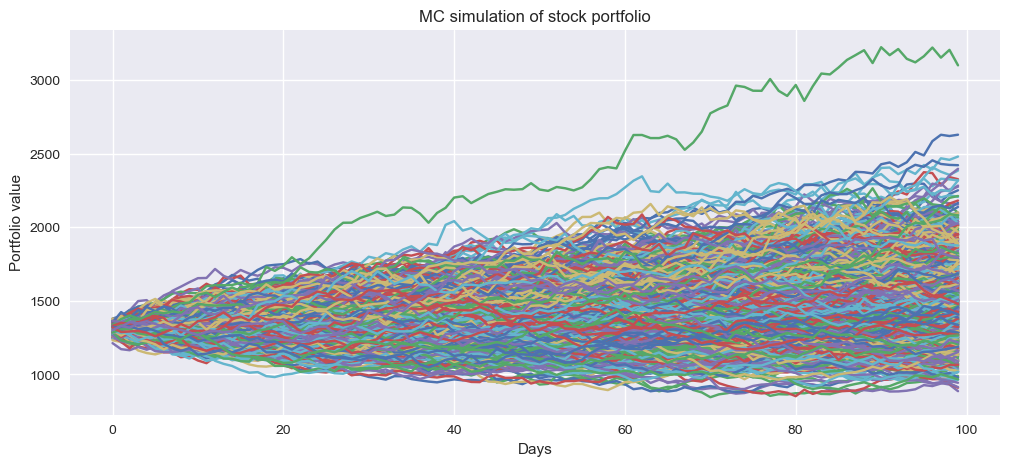

In [19]:
# Monte-Carlo simulation
simulations = 1000
T = 100
mean_mtx = np.full(shape=(T, len(weights)), fill_value=ret).T
portf_simulations = np.full(shape=(T, simulations),fill_value=0.0)
initial_portf = last_price

for i in range(0, simulations):
     Z = np.random.normal(size=(T, len(weights)))
     L = cholesky(cov)
     daily_ret = mean_mtx + np.inner(L,Z)
     portf_simulations[:,i] = np.cumprod(np.inner(weights,daily_ret.T)+1)*initial_portf

plt.figure(figsize=(12,5))
plt.style.use('seaborn')
plt.plot(portf_simulations)
plt.ylabel('Portfolio value')
plt.xlabel('Days')
plt.title('MC simulation of stock portfolio')
plt.show()

